# Preprocesamiento

En esta etapa se toman decisiones en línea con las estadísticas y análisis con tal preparar correctamente los datos que serán parte del entrenamiento y posterior validación de los modelos de predicción

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from nilmtk import DataSet
import warnings
from nilmtk import TimeFrame
warnings. filterwarnings("ignore")
plt.style.use('bmh')

deps = DataSet('C:/data/DEPS.h5')
elec=deps.buildings[1].elec # Todos los medidores

labels = pd.DataFrame({'Instances': list(range(1,11)),
                       'Meters': ['Main_RST', 'Main_R', 'Main_S', 'Main_T', 'Lights_1','Lights_2', 'HVAC_1', 'HVAC_2', 'HVAC_4', 'Rack']})
Meters={}
for x in range(len(labels)): Meters[elec[x+1]]=labels['Meters'][x]

## Cambio en el muestreo de datos e interpolación

### Ejemplo 

Seccion faltante

In [2]:
tf=elec[1].good_sections(full_results=True).combined()[1]
tf

TimeFrame(start='2020-02-27 11:56:40+01:00', end='2020-02-27 17:52:21+01:00', empty=False)

Muestreo cada 10 segundos, promediando datos

In [3]:
ta = '2020-02-27 11:56:20+01:00'
tb = '2020-02-27 11:56:46+01:00'
next(elec[1].load(sample_period=10, resample_kwargs={'fill_method':'ffill', 'how': 'mean'}))[ta:tb]

physical_quantity               power            
type                           active    reactive
2020-02-27 11:56:20+01:00  277.833344 -398.500000
2020-02-27 11:56:30+01:00  277.833344 -398.500000
2020-02-27 11:56:40+01:00  278.399994 -399.899994

Muestreo cada 10 segundos, usando el primer dato

In [4]:
ta = '2020-02-27 11:56:20+01:00'
tb = '2020-02-27 11:56:46+01:00'
next(elec[1].load(sample_period=10, resample_kwargs={'fill_method':'ffill', 'how': 'first'}))[ta:tb]

physical_quantity          power         
type                      active reactive
2020-02-27 11:56:20+01:00  279.0   -400.0
2020-02-27 11:56:30+01:00  279.0   -400.0
2020-02-27 11:56:40+01:00  280.0   -401.0

Código para obtener los datos del medidor principal Main_RST cada 60 segundos.

Además del parámetro sample_period=60, requerido para cambiar el muestreo a un minuto, se ha especificado como método (how) de cambio de muestreo el que provee NILMTK por defecto (mean). En el mismo diccionario resample_kwargs se ha especificado el parámetro fill_method el cual corresponderá al método elegido para rellenar los huecos. En este caso se especifica el método ffill el cual, ante un hueco, rellenará los datos faltantes hacia adelante con el valor inmediatamente anterior a la serie de tiempo

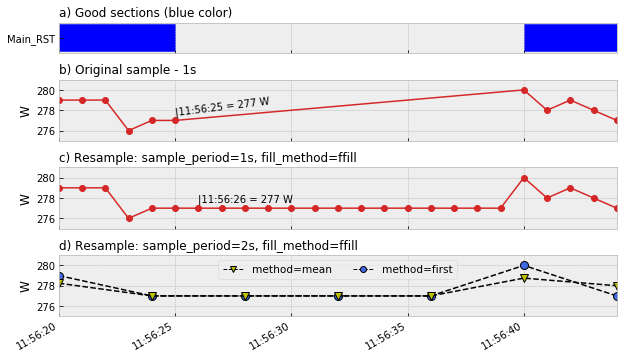

In [5]:
rcParams['figure.figsize'] = (10, 6)

ta = '2020-02-27 11:56:20+01:00'
tb = '2020-02-27 11:56:46+01:00'

Main=elec.select(instance=[1])
fig, (ax4, ax1, ax2, ax3) = plt.subplots(4, 1, sharex=True,
                                         gridspec_kw={'hspace': 0.5,'height_ratios':[1.5, 3, 3, 3]})

elec[1].power_series_all_data()[ta:tb].plot(ax=ax1, color='tab:red', marker="o", lw=1.5)
ax1.minorticks_off()
ax1.set_ylabel('W')
ax1.set_title('b) Original sample - 1s', fontsize=12, loc='left')
ax1.annotate("|11:56:25 = 277 W", xy=('2020-02-27 11:56:25+01:00', 277.6),rotation=7)
ax1.set_ylim(275,281)

elec[1].power_series_all_data(sample_period=1, resample_kwargs={'fill_method': 'ffill'})[ta:tb].plot(ax=ax2, marker="o", color='tab:red',lw=1.5)
ax2.minorticks_off()
ax2.set_ylabel('W')
ax2.set_title('c) Resample: sample_period=1s, fill_method=ffill', fontsize=12, loc='left')
ax2.annotate("|11:56:26 = 277 W", xy=('2020-02-27 11:56:26+01:00', 277.6))
ax2.set_ylim(275,281)

elec[1].power_series_all_data(sample_period=4,resample_kwargs={'how': 'first'})[ta:tb].plot(ax=ax3, color='k', lw=1.5, ls='--', marker="o",
                                                           markersize=8, markerfacecolor='royalblue')
elec[1].power_series_all_data(sample_period=4, resample_kwargs={'how': 'mean'})[ta:tb].plot(ax=ax3, color='k', lw=1.5, ls='--', marker="v",
                          markersize=8, markerfacecolor='y')
ax3.minorticks_off()
ax3.set_ylabel('W')
ax3.set_title('d) Resample: sample_period=2s, fill_method=ffill', fontsize=12, loc='left')
ax3.set_ylim(275,281)

import matplotlib.lines as mlines
line1 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="o", markersize=6, markerfacecolor='royalblue', label='method=first')
line2 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="v", markersize=6, markerfacecolor='y', label='method=mean')
ax3.legend(handles=[line2, line1], fontsize=10.5, ncol=2)
ax4=Main.plot_good_sections(ax=ax4)
ax4.set_yticklabels(list(Meters.values()))
ax4.grid(axis='y')
ax4.set_title('a) Good sections (blue color)', fontsize=12, loc='left')
l=['11:56:20','11:56:25','11:56:30','11:56:35','11:56:40','11:56:45','11:56:50']
ax4.set_xticklabels(l, rotation=30, ha='right')

#guarda gráfico
plt.savefig('C:/data/images/3.1_Prepros_1.svg', bbox_inches='tight', transparent=True)
pass

## Filtros de dispositivos eléctricos

In [6]:
Devices=elec.select(instance=[5,6,7,8,9,10]) #MeterGroup de dispositivos
d=Devices.energy_per_meter().loc['active']  #energía kWh
d[d>5.85] #filtra dispositivos menores o iguales a 5.85 kWh (5% consumo)

6/6 ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])

(5, 1, DEPS)     24.293111
(6, 1, DEPS)     15.208056
(7, 1, DEPS)     16.296233
(8, 1, DEPS)     15.132252
(10, 1, DEPS)    24.032704
Name: active, dtype: float64

*top-k*

In [7]:
Devices = elec.select(instance=[5,6,7,8,9,10])
Devices.select_top_k(k=5)

6/6 ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])
  ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])
)

## División del dataset

- train: conjunto de datos de entrenamiento de modelos de desagregación
- test: conjunto de datos de validación y pruebas de modelos de desagregación

Entrenamiento:

In [8]:
train=DataSet('C:/data/DEPS.h5') #Entrenamiento (Train)
train.set_window(start="2020-02-25 00:00:00", end="2020-03-04 00:00:00")
train_elec=train.buildings[1].elec

train_elec.get_timeframe()

TimeFrame(start='2020-02-25 00:00:00+01:00', end='2020-03-04 00:00:00+01:00', empty=False)

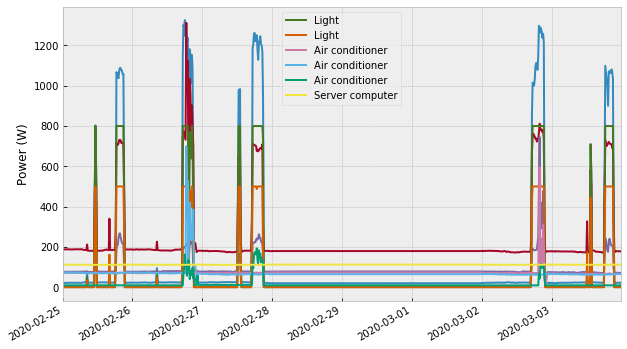

In [9]:
train_elec.submeters().plot()

Validación:

In [10]:
valid=DataSet('C:/data/DEPS.h5') #Validación 
valid.set_window(start="2020-03-04 00:00:00", end="2020-03-07 00:00:00")
valid_elec=valid.buildings[1].elec

valid_elec.get_timeframe()

TimeFrame(start='2020-03-04 00:00:00+01:00', end='2020-03-06 23:59:59+01:00', empty=False)

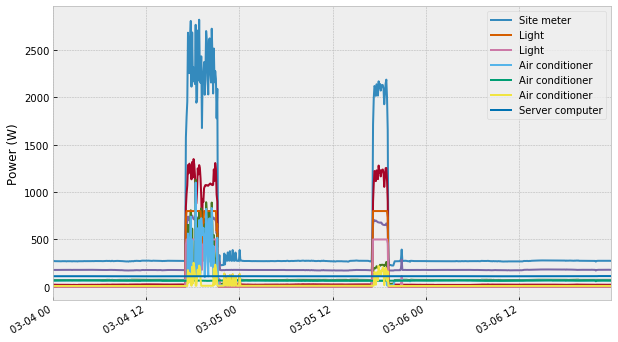

In [11]:
valid_elec.mains().plot()
valid_elec.submeters().plot()

Pruebas:

In [12]:
test=DataSet('C:/data/DEPS.h5') #Pruebas
test.set_window(start="2020-02-24 00:00:00", end="2020-02-25 00:00:00")
test_elec=test.buildings[1].elec

test_elec.get_timeframe()

TimeFrame(start='2020-02-24 00:00:00+01:00', end='2020-02-25 00:00:00+01:00', empty=False)

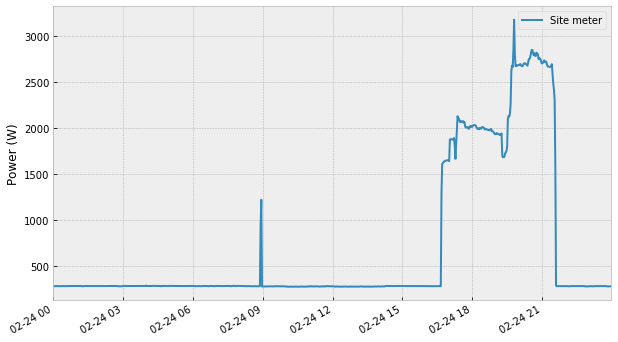

In [13]:
test_elec.mains().plot()

### Función de división

In [14]:
elec.train_test_split(train_fraction=0.7) #70%

Timestamp('2020-03-04 07:11:46.900000+0100', tz='Europe/Madrid')

Calendario:

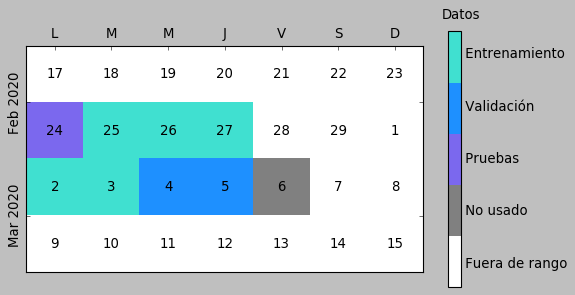

In [15]:
#https://stackoverflow.com/questions/15908371/matplotlib-colorbars-and-its-text-labels
#https://likegeeks.com/seaborn-heatmap-tutorial/
#https://www.pythonprogramming.in/how-to-create-heatmap-calendar-using-numpy-and-matplotlib.html

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

#dataset
num = 28
data=[0, 0, 0, 0, 0, 0, 0,  
      2, 4, 4, 4, 0, 0, 0, 
      4, 4, 3, 3, 1, 0, 0,
      0, 0, 0, 0, 0, 0, 0]
    
start = dt.datetime(2020, 2, 17)
cMap = ListedColormap(['white','gray','mediumslateblue','dodgerblue','turquoise'])
def main(num, data, start):
    plt.style.use('classic')
    dates, data = generate_data(num, data, start)
    fig, ax = plt.subplots(figsize=(8, 4)) 
    calendar_heatmap(ax, dates, data)
    plt.savefig('C:/data/images/3.2_Calendario_2.pdf', bbox_inches='tight', transparent=True)    
    plt.show()    
def generate_data(num, data, start):
    dates = [start + dt.timedelta(days=i) for i in range(num)]
    return dates, data 
def calendar_array(dates, data):
    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1
    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar 
def calendar_heatmap(ax, dates, data):
    i, j, calendar = calendar_array(dates, data)
    im = ax.imshow(calendar, interpolation='none', cmap=cMap) #'Set3'
    label_days(ax, dates, i, j, calendar)
    label_months(ax, dates, i, j, calendar)   
    cbar = plt.colorbar(im)
    cbar.ax.get_yaxis().set_ticks([])
    for j, lab in enumerate([' Fuera de rango',' No usado',' Pruebas',' Validación',' Entrenamiento']):       
        #cbar.ax.text(4, 0.01, lab, ha='left', va='center',rotation=0)
        cbar.ax.text(4, (18 * j + 8)/22.0, lab, ha='left', va='center',rotation=0)  
    cbar.ax.grid(which="minor", color="black", linewidth=6)
    cbar.ax.get_yaxis().labelpad = 0
    cbar.ax.set_ylabel('Datos', rotation=0, y=1.09, ha='center')
def label_days(ax, dates, i, j, calendar):
    ni, nj = calendar.shape
    day_of_month = np.nan * np.zeros((ni, 7))
    day_of_month[i, j] = [d.day for d in dates]
    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center') 
    ax.set(xticks=np.arange(7), xticklabels=['L', 'M', 'M', 'J', 'V', 'S', 'D'])
    ax.xaxis.tick_top()
def label_months(ax, dates, i, j, calendar):
    yticks = [-0.5,0.5,2.5,3.5]
    labels = ['','Feb 2020', 'Mar 2020', '']
    ax.set(yticks=yticks)
    ax.set_yticklabels(labels, rotation=90)

main(num, data, start)